In [7]:
import pandas as pd
import numpy as np
import os
import sys
from sklearn.metrics import mean_absolute_error
from scipy.stats import gmean
from scipy.optimize import minimize
module_path = "../src"
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.utils import *   
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_rows', 9999)

In [8]:
def post_processing(df,DATA_PATH = '../Data',col = 'oof'):
    '''
    Postprocessing for previos values of target_mes equal 0 in train data:
    '''
    train_df = pd.read_csv(os.path.join(DATA_PATH,'Data desafío BCI Challenge','train_data.csv'))[['id','mes','target_mes']]
    train_df = train_df[train_df['mes']<=202104].reset_index(drop = True)
    tmp   = train_df.groupby(['id']).agg({'target_mes':'mean'}).reset_index()
    ids_0 = list((set(tmp[tmp['target_mes']==0].id)&set(df.id.unique())))
    df.loc[df['id'].isin(ids_0),col] = 0
    return df    

## Past Model for New Clients

In [33]:
MODEL_PATH_PAST  = '../SavedModels/model_past'
MODE_PAST        = 'gmean'   # ['mean','median','gmean','optimize']        

In [34]:
models_past = ['ligthgbm_featureset2_model_past_target_sqrt',
               'ligthgbm_featureset2_model_past_target_log',
               'catboost_featureset2_model_past_target_sqrt']


In [35]:
ref_train = get_train_data('folds_new_clients_model.parquet.gzip')[['id','mes','target_mes']]
ref_test  = get_test_data(segment = 'groupkfold_client')[['id','mes']]

for idx,model in enumerate(models_past):
    # Train
    tmp = pd.read_csv(os.path.join(MODEL_PATH_PAST,model,'oof.csv')).rename(columns = {'oof':f'oof_{idx+1}'})
    tmp[f'oof_{idx+1}'] = tmp[f'oof_{idx+1}'].clip(0)
    ref_train = ref_train.merge(tmp,on = ['id','mes'],how = 'left')
    # Test
    tmp = pd.read_csv(os.path.join(MODEL_PATH_PAST,model,'part1_test.csv')).rename(columns = {'preds':f'preds_{idx+1}'})
    tmp[f'preds_{idx+1}'] = tmp[f'preds_{idx+1}'].clip(0)
    ref_test = ref_test.merge(tmp,on = ['id','mes'],how = 'left')
    print(f'********** {model} ************ ')
    print(f"Median oof {ref_train[f'oof_{idx+1}'].median()}, Median target {ref_train['target_mes'].median()}, Median test {ref_test[f'preds_{idx+1}'].median()}")
    print(f"OOF Model - {model}: {mean_absolute_error(ref_train[f'oof_{idx+1}'],ref_train['target_mes'])}")

********** ligthgbm_featureset2_model_past_target_sqrt ************ 
Median oof 24.24468298321991, Median target 25.72, Median test 23.469473468296556
OOF Model - ligthgbm_featureset2_model_past_target_sqrt: 99.5820437493367
********** ligthgbm_featureset2_model_past_target_log ************ 
Median oof 23.34828409905633, Median target 25.72, Median test 22.61180534891541
OOF Model - ligthgbm_featureset2_model_past_target_log: 100.30119485643652
********** catboost_featureset2_model_past_target_sqrt ************ 
Median oof 26.676359427444034, Median target 25.72, Median test 25.853180712661768
OOF Model - catboost_featureset2_model_past_target_sqrt: 101.43915807108428


In [36]:
oof_cols   = [f for f in ref_train.columns.to_list() if 'oof_' in f]
preds_cols = [f for f in ref_test.columns.to_list() if 'preds_' in f]
if MODE_PAST == 'mean':
    ref_train['ensemble_oof'] = ref_train[oof_cols].mean(axis =1)
    ref_test['ensemble_preds'] = ref_test[preds_cols].mean(axis =1)
elif MODE_PAST == 'median':
    ref_train['ensemble_oof'] = ref_train[oof_cols].median(axis = 1)
    ref_test['ensemble_preds'] = ref_test[preds_cols].median(axis = 1)
elif MODE_PAST == 'gmean':
    ref_train['ensemble_oof'] = gmean(ref_train[oof_cols].values,axis =1)
    ref_test['ensemble_preds'] = gmean(ref_test[preds_cols].values,axis =1)
elif MODE_PAST == 'optimize':
    X = ref_train[oof_cols].values
    y = ref_train['target_mes'].values
    for oof_idx in range(X.shape[1]):
        print(f'OOF {oof_idx+1}: ',mean_absolute_error(X[:,oof_idx],y))    
    x0 = np.array([1/X.shape[1]]*X.shape[1])
    def cost(x0):
        a = np.mean(np.abs((y - np.sum(X*x0, -1))))
        return a
    bnds = tuple([(0,1)]*X.shape[1]) # Weights have to be between 0 and 1.
    cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)}) # Sum of the weights will be 1.
    res = minimize(cost, x0, bounds=bnds,options = {'disp':True})
    print(f"OOF ENSEMBLE-{MODE_PAST}: {res.fun}")
    
    ### Get train enseble and test
    oof_final   = 0
    preds_final = 0
    print('Weights:',res.x)
    for idx,w in enumerate(res.x):
        oof_final   += ref_train[oof_cols].values[:,idx]*w
        preds_final += ref_test[preds_cols].values[:,idx]*w
    ref_train['ensemble_oof']   = oof_final
    ref_test ['ensemble_preds'] = preds_final
print(f"OOF ENSEMBLE-{MODE_PAST}: {mean_absolute_error(ref_train['target_mes'],ref_train['ensemble_oof'])}")

OOF ENSEMBLE-gmean: 98.58070176739686


/opt/conda/envs/rapids/lib/python3.8/site-packages/scipy/stats/stats.py:410: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)


25.72 24.644223567993464 23.885002443773146


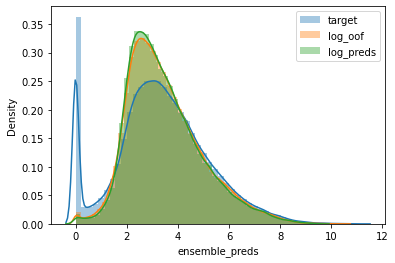

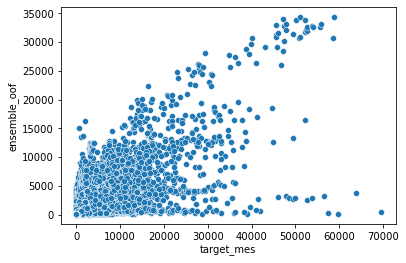

In [37]:
print(ref_train['target_mes'].median(),ref_train['ensemble_oof'].median(),ref_test['ensemble_preds'].median())
sns.distplot(np.log(ref_train['target_mes']+1),label = 'target')
sns.distplot(np.log(ref_train['ensemble_oof']+1),label = 'log_oof')
sns.distplot(np.log(ref_test['ensemble_preds']+1),label = 'log_preds')
plt.legend()
plt.show()
sns.scatterplot(ref_train['target_mes'],ref_train['ensemble_oof'])
plt.show()

In [38]:
ref_test_part1 = ref_test.copy()[['id','mes','ensemble_preds']]

In [39]:
#ref_train[['id','mes','ensemble_oof']].to_csv('not_historic_info_clients.csv',index = False)

In [40]:
del ref_train,ref_test

# Future Model

In [41]:
MODEL_PATH_FUTURE  = '../SavedModels/model_future'
MODE_FUTURE        = 'gmean'   # ['mean','median','gmean','optimize']        

In [42]:
models_future = ['ligthgbm_featureset2_model_future_target_sqrt_after_202004',
                 'catboost_featureset2_model_future_target_sqrt_after_202004']

In [43]:
ref_train = get_train_data('folds_new_clients_model.parquet.gzip')[['id','mes','target_mes']]
ref_train = ref_train[ref_train['mes']>=202004].reset_index(drop = True)
ref_test  = get_test_data(segment = 'not_behavoir_future')[['id','mes']]

for idx,model in enumerate(models_future):
    # Train
    tmp = pd.read_csv(os.path.join(MODEL_PATH_FUTURE,model,'oof.csv')).rename(columns = {'oof':f'oof_{idx+1}'})
    tmp[f'oof_{idx+1}'] = tmp[f'oof_{idx+1}'].clip(0)
    ref_train = ref_train.merge(tmp,on = ['id','mes'],how = 'left')
    # Test
    tmp = pd.read_csv(os.path.join(MODEL_PATH_FUTURE,model,'part3_test.csv')).rename(columns = {'preds':f'preds_{idx+1}'})
    tmp[f'preds_{idx+1}'] = tmp[f'preds_{idx+1}'].clip(0)
    ref_test = ref_test.merge(tmp,on = ['id','mes'],how = 'left')
    print(f'********** {model} ************ ')
    print(f"Median oof {ref_train[f'oof_{idx+1}'].median()}, Median target {ref_train['target_mes'].median()}, Median test {ref_test[f'preds_{idx+1}'].median()}")
    print(f"OOF Model - {model}: {mean_absolute_error(ref_train[f'oof_{idx+1}'],ref_train['target_mes'])}")

********** ligthgbm_featureset2_model_future_target_sqrt_after_202004 ************ 
Median oof 21.67934049169342, Median target 23.03, Median test 24.436543227367128
OOF Model - ligthgbm_featureset2_model_future_target_sqrt_after_202004: 98.43744156365767
********** catboost_featureset2_model_future_target_sqrt_after_202004 ************ 
Median oof 23.81030984944772, Median target 23.03, Median test 26.621966046369074
OOF Model - catboost_featureset2_model_future_target_sqrt_after_202004: 99.61059612022329


In [44]:
oof_cols   = [f for f in ref_train.columns.to_list() if 'oof_' in f]
preds_cols = [f for f in ref_test.columns.to_list() if 'preds_' in f]
if MODE_FUTURE == 'mean':
    ref_train['ensemble_oof'] = ref_train[oof_cols].mean(axis =1)
    ref_test['ensemble_preds'] = ref_test[preds_cols].mean(axis =1)
elif MODE_FUTURE == 'median':
    ref_train['ensemble_oof'] = ref_train[oof_cols].median(axis = 1)
    ref_test['ensemble_preds'] = ref_test[preds_cols].median(axis = 1)
elif MODE_FUTURE == 'gmean':
    ref_train['ensemble_oof'] = gmean(ref_train[oof_cols].values,axis =1)
    ref_test['ensemble_preds'] = gmean(ref_test[preds_cols].values,axis =1)
elif MODE_FUTURE == 'optimize':
    X = ref_train[oof_cols].values
    y = ref_train['target_mes'].values
    for oof_idx in range(X.shape[1]):
        print(f'OOF {oof_idx+1}: ',mean_absolute_error(X[:,oof_idx],y))    
    x0 = np.array([1/X.shape[1]]*X.shape[1])
    def cost(x0):
        a = np.mean(np.abs((y - np.sum(X*x0, -1))))
        return a
    bnds = tuple([(0,1)]*X.shape[1]) # Weights have to be between 0 and 1.
    cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)}) # Sum of the weights will be 1.
    res = minimize(cost, x0, bounds=bnds,options = {'disp':True})
    print(f"OOF ENSEMBLE-{MODE_FUTURE}: {res.fun}")
    
    ### Get train enseble and test
    oof_final   = 0
    preds_final = 0
    print('Weights:',res.x)
    for idx,w in enumerate(res.x):
        oof_final   += ref_train[oof_cols].values[:,idx]*w
        preds_final += ref_test[preds_cols].values[:,idx]*w
    ref_train['ensemble_oof']   = oof_final
    ref_test ['ensemble_preds'] = preds_final
print(f"OOF ENSEMBLE-{MODE_FUTURE}: {mean_absolute_error(ref_train['target_mes'],ref_train['ensemble_oof'])}")

OOF ENSEMBLE-gmean: 97.43446689227082


23.03 22.630716842975257 25.374553797664586


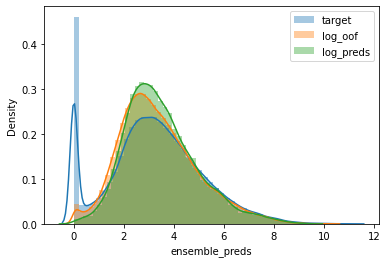

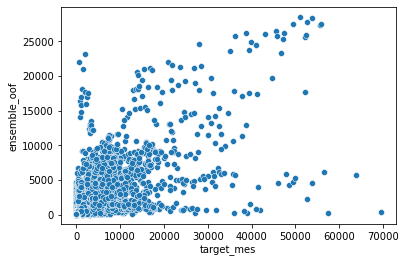

In [45]:
print(ref_train['target_mes'].median(),ref_train['ensemble_oof'].median(),ref_test['ensemble_preds'].median())
sns.distplot(np.log(ref_train['target_mes']+1),label = 'target')
sns.distplot(np.log(ref_train['ensemble_oof']+1),label = 'log_oof')
sns.distplot(np.log(ref_test['ensemble_preds']+1),label = 'log_preds')
plt.legend()
plt.show()
sns.scatterplot(ref_train['target_mes'],ref_train['ensemble_oof'])
plt.show()

In [46]:
ref_test_part3 = ref_test.copy()[['id','mes','ensemble_preds']]

In [47]:
del ref_train,ref_test

## Model Behavior

In [48]:
MODEL_PATH_BEHAVIOR  = '../SavedModels/model_behavior'
MODE_BEHAVIOR        = 'mean'   # ['mean','median','gmean','optimize']     

In [49]:
models_behavior = ['lightgbm_v0_behavior_mes_202004']

In [50]:
ref_train = get_train_data('folds_behavior_clients_model.parquet.gzip')[['id','mes','target_mes']]
ref_train = ref_train[ref_train['mes']>=202004].reset_index(drop = True)
ref_test  = get_test_data(segment = 'behavior_future')[['id','mes']]

for idx,model in enumerate(models_behavior):
    # Train
    tmp = pd.read_csv(os.path.join(MODEL_PATH_BEHAVIOR,model,'oof.csv')).rename(columns = {'oof':f'oof_{idx+1}'})
    tmp[f'oof_{idx+1}'] = tmp[f'oof_{idx+1}'].clip(0)
    ref_train = ref_train.merge(tmp,on = ['id','mes'],how = 'left')
    # Test
    tmp = pd.read_csv(os.path.join(MODEL_PATH_BEHAVIOR,model,'part2_test.csv')).rename(columns = {'preds':f'preds_{idx+1}'})
    tmp[f'preds_{idx+1}'] = tmp[f'preds_{idx+1}'].clip(0)
    ref_test = ref_test.merge(tmp,on = ['id','mes'],how = 'left')
    print(f'********** {model} ************ ')
    print(f"Median oof {ref_train[f'oof_{idx+1}'].median()}, Median target {ref_train['target_mes'].median()}, Median test {ref_test[f'preds_{idx+1}'].median()}")
    print(f"OOF Model - {model}: {mean_absolute_error(ref_train[f'oof_{idx+1}'],ref_train['target_mes'])}")

********** lightgbm_v0_behavior_mes_202004 ************ 
Median oof 21.286808871303244, Median target 22.64, Median test 25.459618877630795
OOF Model - lightgbm_v0_behavior_mes_202004: 53.760644932263915


In [51]:
oof_cols   = [f for f in ref_train.columns.to_list() if 'oof_' in f]
preds_cols = [f for f in ref_test.columns.to_list() if 'preds_' in f]
if MODE_BEHAVIOR == 'mean':
    ref_train['ensemble_oof'] = ref_train[oof_cols].mean(axis =1)
    ref_test['ensemble_preds'] = ref_test[preds_cols].mean(axis =1)
elif MODE_BEHAVIOR == 'median':
    ref_train['ensemble_oof'] = ref_train[oof_cols].median(axis = 1)
    ref_test['ensemble_preds'] = ref_test[preds_cols].median(axis = 1)
elif MODE_BEHAVIOR == 'gmean':
    ref_train['ensemble_oof'] = gmean(ref_train[oof_cols].values,axis =1)
    ref_test['ensemble_preds'] = gmean(ref_test[preds_cols].values,axis =1)
elif MODE_BEHAVIOR == 'optimize':
    X = ref_train[oof_cols].values
    y = ref_train['target_mes'].values
    for oof_idx in range(X.shape[1]):
        print(f'OOF {oof_idx+1}: ',mean_absolute_error(X[:,oof_idx],y))    
    x0 = np.array([1/X.shape[1]]*X.shape[1])
    def cost(x0):
        a = np.mean(np.abs((y - np.sum(X*x0, -1))))
        return a
    bnds = tuple([(0,1)]*X.shape[1]) # Weights have to be between 0 and 1.
    cons = ({'type': 'eq', 'fun': lambda x:  1 - sum(x)}) # Sum of the weights will be 1.
    res = minimize(cost, x0, bounds=bnds,options = {'disp':True})
    print(f"OOF ENSEMBLE-{MODE_BEHAVIOR}: {res.fun}")
    print(res.x)
    ### Get train enseble and test
    oof_final   = 0
    preds_final = 0
    print('Weights:',res.x)
    for idx,w in enumerate(res.x):
        oof_final   += ref_train[oof_cols].values[:,idx]*w
        preds_final += ref_test[preds_cols].values[:,idx]*w
    ref_train['ensemble_oof']   = oof_final
    ref_test ['ensemble_preds'] = preds_final
print(f"OOF ENSEMBLE-{MODE_BEHAVIOR}: {mean_absolute_error(ref_train['target_mes'],ref_train['ensemble_oof'])}")

OOF ENSEMBLE-mean: 53.760644932263915


22.64 21.286808871303244 25.459618877630795


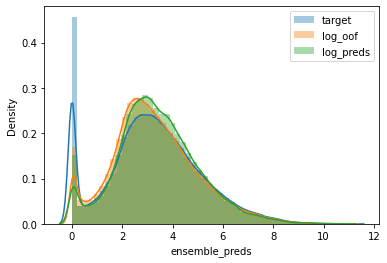

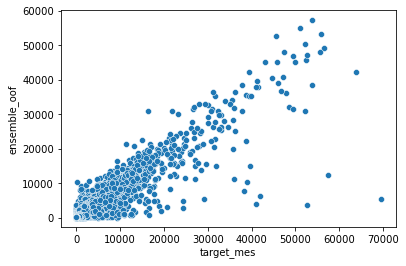

In [52]:
print(ref_train['target_mes'].median(),ref_train['ensemble_oof'].median(),ref_test['ensemble_preds'].median())
sns.distplot(np.log(ref_train['target_mes']+1),label = 'target')
sns.distplot(np.log(ref_train['ensemble_oof']+1),label = 'log_oof')
sns.distplot(np.log(ref_test['ensemble_preds']+1),label = 'log_preds')
plt.legend()
plt.show()
sns.scatterplot(ref_train['target_mes'],ref_train['ensemble_oof'])
plt.show()

In [53]:
ref_test_part2 = ref_test.copy()[['id','mes','ensemble_preds']]

In [54]:
#ref_train[['id','mes','ensemble_oof']].to_csv('historic_info_clients.csv',index = False)

In [55]:
del ref_train,ref_test

## Final Submission

In [56]:
concat_df = []
for df in [ref_test_part1,ref_test_part2,ref_test_part3]:
    concat_df.append(df)
concat_df = pd.concat(concat_df).rename(columns = {'ensemble_preds':'target_mes'})

In [57]:
print('Concat Shape',concat_df.shape)
test_all = pd.read_csv('../Data/Data desafío BCI Challenge/test_data.csv')[['id','mes']]
assert concat_df.shape[0] == test_all.shape[0]

Concat Shape (292016, 3)


In [58]:
sub = test_all.merge(concat_df,on = ['id','mes'],how = 'left')
assert sub.shape[0] == test_all.shape[0]

In [59]:
sub.head()

,id,mes,target_mes
0,8ae0058fa056,202105,19.868638
1,8a4fc1159dee,202106,72.393158
2,278764d539dd,202108,3.131776
3,59ec2caa4756,202107,24.144920
4,8a4fc1159dee,202105,80.192170


In [60]:
sub = post_processing(sub,DATA_PATH = '../Data',col = 'target_mes')

In [61]:
sub.to_csv('../Submission/final_ensemble_submission.csv',index = False)